In [1]:
from pybioportal import clinical_data as cd

In [2]:
data = cd.fetch_all_clinical_data_in_study(study_id="brca_tcga",
                                           attribute_ids=["OS_STATUS", "OS_MONTHS", "RACE"],
                                           clinical_data_type="PATIENT", ret_format="WIDE")

In [3]:
import pandas as pd
import numpy as np

def prepare_data_for_kaplan_meier(dataframe, status_column, months_column):
    
    surv_data = dataframe.copy()
    
    # delete rows with NaN values on status columns 
    surv_data.dropna(subset=[status_column, months_column], inplace=True)
    
    # convert months from string to float 
    surv_data[months_column] = surv_data[months_column].astype(float)
    
    # delete negative months
    surv_data = surv_data[surv_data[months_column] >= 0]
    
    # convert survival status from string to int
    def map_status(x):
        if pd.isnull(x):
            return np.nan
        else:
            try:
                return int(x.split(":")[0])
            except ValueError:
                return np.nan
    
    surv_data[status_column] = surv_data[status_column].apply(map_status)
    
    return surv_data

In [4]:
surv_data = prepare_data_for_kaplan_meier(data, "OS_STATUS", "OS_MONTHS")

In [5]:
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt


# Initialize Kaplan-Meier fitter
kmf = KaplanMeierFitter()

T = surv_data["OS_MONTHS"] # time
E = surv_data["OS_STATUS"] # event


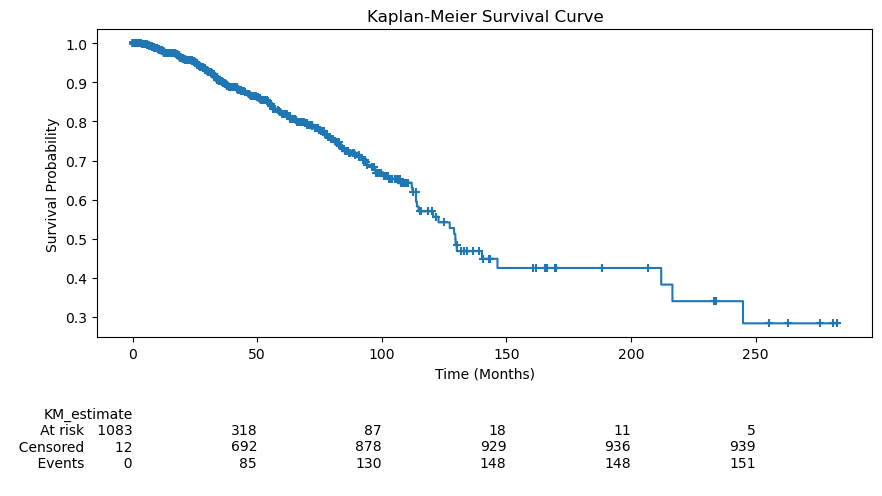

In [17]:
# Fitting Kaplan-Meier model
kmf.fit(T, event_observed=E)

plt.figure(figsize=(10,4))

# Plot surv function
ax = kmf.plot_survival_function(ci_show=False)

# Setting symbol and dimension of censored values
censored_times = surv_data[E == 0]["OS_MONTHS"]
censored_probs = kmf.survival_function_.loc[censored_times].values.flatten()
ax.scatter(censored_times, censored_probs, marker="+", s=30)

plt.title("Kaplan-Meier Survival Curve")
plt.xlabel("Time (Months)")
plt.ylabel("Survival Probability")
plt.legend().remove()

# from lifelines.plotting import add_at_risk_counts
add_at_risk_counts(kmf, ax=ax)
plt.show()

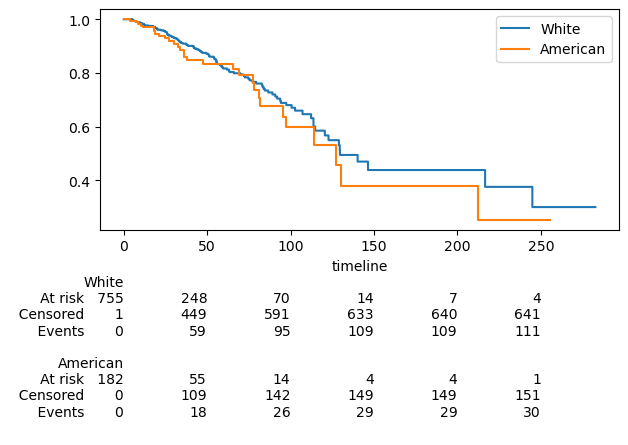

In [18]:
#plt.figure(figsize=(10,8))
ax = plt.subplot(111)


race_w = (surv_data["RACE"] == "WHITE")
race_a = (surv_data["RACE"] == "BLACK OR AFRICAN AMERICAN")

kmf_w = KaplanMeierFitter()

kmf_w.fit(T[race_w], event_observed=E[race_w], label="White")
kmf_w.plot_survival_function(ax=ax, ci_show=False)

kmf_a = KaplanMeierFitter()
kmf_a.fit(T[race_a], event_observed=E[race_a], label="American")
kmf_a.plot_survival_function(ax=ax, ci_show=False)

from lifelines.plotting import add_at_risk_counts
add_at_risk_counts(kmf_w, kmf_a, ax=ax)
plt.tight_layout()

In [121]:
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter
from lifelines.plotting import add_at_risk_counts

def plot_survival_curves(dataframe, event_column, time_column, stratify_column=None, stratify_values=None,
                         censored_marker='+', censored_size=30,
                         add_risk_cnt=False,
                         figsize=(8,4),
                         title="Kaplan-Meier Survival Curve",
                         xlabel="Time (Months)",
                         ylabel="Survival Probability"):
    
    df_var = None
    for name, var in globals().items():
        if isinstance(var, pd.DataFrame) and var.equals(dataframe):
            df_var = name
            break
    
    if stratify_column and stratify_column not in dataframe.columns:
        raise ValueError(f"Column '{stratify_column}' not present in '{df_var}' DataFrame.")
    
    if figsize:
        plt.figure(figsize=figsize)

    ax = plt.subplot(111)    

    if stratify_column:
        if stratify_values is None:
            stratify_values = dataframe[stratify_column].dropna().unique()
        elif isinstance(stratify_values, str):
            stratify_values = [stratify_values]
        elif not isinstance(stratify_values, list) or not all(isinstance(val, str) for val in stratify_values):
            raise ValueError("The 'stratify_values' parameter must be a list of str")    
        else:
            for val in stratify_values:
                if val not in dataframe[stratify_column].unique():
                    raise ValueError(f"Value '{val}' not present in the column '{stratify_column}' of '{df_var}' DataFrame")

        kmf_dict = {}
        for val in stratify_values:
            mask = (dataframe[stratify_column] == val)
            kmf_dict[val] = KaplanMeierFitter()
            kmf_dict[val].fit(dataframe[mask][time_column], event_observed=dataframe[mask][event_column], label=str(val))
            kmf_dict[val].plot_survival_function(ax=ax, ci_show=False)

            if censored_marker is not None:
                censored_times = dataframe[mask & (dataframe[event_column] == 0)][time_column]
                censored_probs = kmf_dict[val].survival_function_.loc[censored_times].values.flatten()
                ax.scatter(censored_times, censored_probs, marker=censored_marker, s=censored_size)

        plt.title(title)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        if add_risk_cnt: 
            add_at_risk_counts(*[kmf_dict[val] for val in kmf_dict.keys()], ax=ax)
    else:
        kmf = KaplanMeierFitter()
        kmf.fit(dataframe[time_column], event_observed=dataframe[event_column])
        kmf.plot_survival_function(ax=ax, ci_show=False)

        if censored_marker is not None:
            censored_times = dataframe[dataframe[event_column] == 0][time_column]
            censored_probs = kmf.survival_function_.loc[censored_times].values.flatten()
            ax.scatter(censored_times, censored_probs, marker=censored_marker, s=censored_size)
            
        plt.title(title)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)         
        plt.legend().remove()
        if add_risk_cnt:
            add_at_risk_counts(kmf, ax=ax)
       
    plt.show()

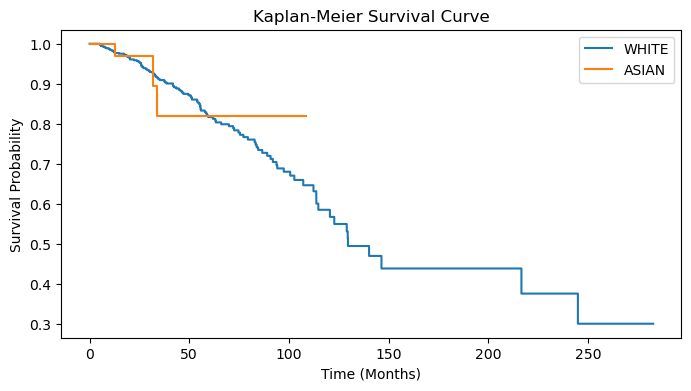

In [125]:
plot_survival_curves(surv_data, "OS_STATUS", "OS_MONTHS", stratify_column="RACE", stratify_values=["WHITE", "ASIAN"], censored_marker=None)